# Определение перспективного тарифа для телеком компании.

В нашем распоряжении данные компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческому департаменту необходимо понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Изучим общую информацию.

In [14]:
import pandas as pd
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

#display(calls.info(), internet.info(), messages.info(),tariffs.info(), users.info())

### Вывод

В нашем распоряжении 5 таблиц с данными о клиентах телеком компании "Мегалайн". Пропущенных значений в таблицах нет, за исключением таблицы __*users*__, столбец __*churn_date*__. Но нам известно, если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Также в некоторых столбцах каждой таблицы имеется несоответствие с типом данных. Пропробуем преобразовать типы и подготовить данные к дальнейшей обработке.

### Шаг 2. Подготовим данные

In [15]:
#изменяем тип данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')

In [16]:
#избавиляемся от 0 в длительности звонка и в интернет трафике
import numpy as np
calls[calls['duration'] == 0.00] = calls[calls['duration'] == 0.00].replace(0.00,1.00)
internet[internet['mb_used'] == 0.00] = internet[internet['mb_used'] == 0.00].replace(0.00,1.00)

#округляем данные согласно условию Мегалайн
calls['duration'] = np.ceil(calls['duration']).astype('int')
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')

Компания Мегалайн всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Согласно этому условию, мы округлили значения в минутах и использованном трафике. Также, нулевую длительность звонков и израсходованный интернет-трафик заменили на 1. Предположили, что 0.00 это некорректная выгрузка данных или ошибка записи.

In [17]:
#выделяем месяц из данных даты.
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month
users['month'] = users['reg_date'].dt.month

month_name = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь',
              'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
month_fl = 1
for name in month_name:
    calls['month'] = calls['month'].replace(month_fl,name)
    internet['month'] = internet['month'].replace(month_fl,name)
    messages['month'] = messages['month'].replace(month_fl,name)
    users['month'] = users['month'].replace(month_fl,name)
    month_fl +=1

In [18]:
#расходы пользователей по месяцам (смс, звонки, интернет)
calls_month = calls.groupby(['user_id','month'], as_index=False)[['id','duration']].agg({'id':['count'], 'duration':[sum]})
messages_month = messages.groupby(['user_id', 'month'], as_index=False).agg({'id':['count']})
internet_month = internet.groupby(['user_id', 'month'], as_index=False).agg({'mb_used':[sum]})

#переименовываем столбцы, избавляясь от мультиндексов
calls_month.columns = ['user_id', 'month', 'count_calls', 'count_duration']
messages_month.columns = ['user_id', 'month', 'count_messages']
internet_month.columns = ['user_id', 'month', 'mb_per_month']

#объединяем данные в одну таблицу
data_per_month_temp = calls_month.merge(messages_month, on = ['user_id', 'month'], how = 'outer')
data_per_month = data_per_month_temp.merge(internet_month, on = ['user_id', 'month'], how = 'outer')

In [19]:
#считаем помесячную выручку с каждого пользователя
users_tariff = users[['user_id', 'tariff']] 
data_tariff = data_per_month.merge(users_tariff, on = ['user_id'], how = 'inner')
data_tariff.columns = ['user_id', 'month', 'count_calls', 'count_duration', 
                       'count_messages', 'mb_per_month', 'tariff_name']

data_tariff['count_calls'] = data_tariff['count_calls'].fillna(0)
data_tariff['count_duration'] = data_tariff['count_duration'].fillna(0)
data_tariff['mb_per_month'] = data_tariff['mb_per_month'].fillna(0)
data_tariff['count_messages'] = data_tariff['count_messages'].fillna(0)

all_data = data_tariff.merge(tariffs, on = ['tariff_name'], how = 'outer')#общая таблица с ежемесячными расходами и тарифами

for i in range(0,len(all_data)):#помесячная выручка:
    ov_call = all_data.loc[i,'count_duration'] - all_data.loc[i,'minutes_included']
    ov_mess = all_data.loc[i,'count_messages'] - all_data.loc[i,'messages_included']
    ov_inet = np.ceil((all_data.loc[i,'mb_per_month'] - all_data.loc[i,'mb_per_month_included'])/1024)
    if ov_call <0:
        ov_call = 0
    if ov_mess <0:
        ov_mess = 0
    if ov_inet <0:
        ov_inet = 0
    re_call = ov_call * all_data.loc[i,'rub_per_minute']
    re_mess = ov_mess * all_data.loc[i,'rub_per_message']
    re_inet = ov_inet * all_data.loc[i,'rub_per_gb']
    re_abon = all_data.loc[i,'rub_monthly_fee']
    re_sum = re_call + re_mess + re_inet + re_abon
    all_data.loc[i,'revenue'] = re_sum
    
#добавили столбец с выручкой. теперь all_data -  таблица с расходами, тарифами и выручкой пользователей по месяцам.
#display(all_data.head())
  

In [20]:
all_data

,user_id,month,count_calls,count_duration,count_messages,mb_per_month,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,Август,52.0,418.0,81.0,14072.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,Декабрь,46.0,341.0,70.0,9829.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,Июль,47.0,346.0,75.0,14017.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,Июнь,43.0,187.0,60.0,23262.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,Май,22.0,164.0,22.0,2257.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,Август,0.0,0.0,17.0,11072.0,smart,50,15360,500,550,200,3,3,550.0
3210,1489,Декабрь,0.0,0.0,35.0,17349.0,smart,50,15360,500,550,200,3,3,950.0
3211,1489,Ноябрь,0.0,0.0,20.0,17526.0,smart,50,15360,500,550,200,3,3,1150.0
3212,1489,Октябрь,0.0,0.0,21.0,19599.0,smart,50,15360,500,550,200,3,3,1550.0


Для расчета расходов каждого пользователя по месяцам, объединили таблицы __*calls*__, __*messages*__ и __*internet*__ в одну общую __*data_tariff*__. После этого в таблице появились пропущенные значения. Для возможности дальнейшего анализа, заменили все пропущенные значения 0. Далее расчитали помесячную выручку с каждого пользователя согласно тарифам Мегалайн.

### Шаг 3. Анализ данных

In [21]:
#Среднее количество звонков, смс и интернета
mean_tariff = all_data.groupby(['tariff_name']).agg({'count_duration':['mean'], 
                                                     'count_messages':['mean'], 
                                                     'mb_per_month':['mean']})

compare_tariff = tariffs[['tariff_name', 'minutes_included', 'messages_included', 'mb_per_month_included']]

display(mean_tariff, compare_tariff)

,count_duration,count_messages,mb_per_month
,mean,mean,mean
tariff_name,,,
smart,429.450875,33.384029,16237.184388
ultra,540.779695,49.363452,19488.703553


,tariff_name,minutes_included,messages_included,mb_per_month_included
0,smart,500,50,15360
1,ultra,3000,1000,30720


Посчитав средние значения длительности звонков, количества отправленных сообщений и использованного интернет-трафика, можно сделать вывод, что пользователи укладываются в лимиты тарифов, за исключением тарифа "Смарт": среднее протребление интернет-трафика превышает лимит.

In [22]:
#дисперсия по выборке
variance_estimate = np.var(all_data[['count_duration', 'count_messages', 'mb_per_month']], ddof=1)
#стандартное отклонение
standard_deviation = np.std(all_data[['count_duration', 'count_messages', 'mb_per_month']],ddof=1)

display(variance_estimate, standard_deviation)

count_duration    6.146360e+04
count_messages    1.306701e+03
mb_per_month      5.744445e+07
dtype: float64

count_duration     247.918544
count_messages      36.148326
mb_per_month      7579.211552
dtype: float64

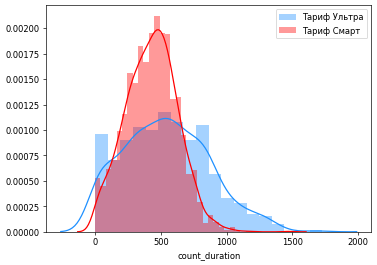

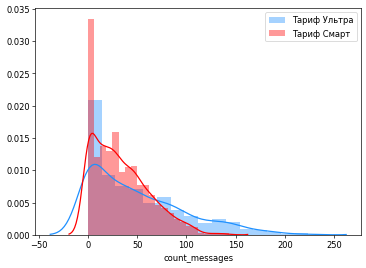

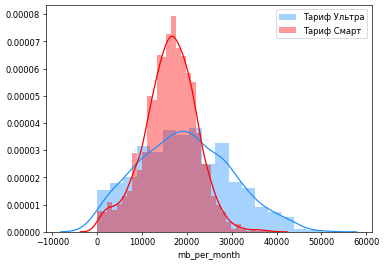

In [23]:
import seaborn
import matplotlib.pyplot as plt
tariff_ultra = all_data.query('tariff_name == "ultra"').copy()       
tariff_smart = all_data.query('tariff_name == "smart"').copy()        

colums = ['count_duration', 'count_messages', 'mb_per_month']
for row in colums:
    plt.figure(figsize=(7,5), dpi= 60)
    seaborn.distplot(tariff_ultra[row], bins = 'auto', label='Тариф Ультра', color='dodgerblue')
    seaborn.distplot(tariff_smart[row],bins = 'auto', label='Тариф Смарт', color='red')
    plt.legend(loc='upper right')
    plt.xlabel(row)
    plt.show()    

По графикам мы видим, что данные выборки имеют нормальное распределение (Пуассона). Пик приходится на средние значения, кроме, графика отправленных сообщений. Пик - количество сообщений от 0-10. Особенно у тарифа Смарт -  преобладает малое количество отправленных смс. Вероятнее всего это связано с популярностью мессенджеров, работающих через интернет - Whatsapp, Viber, Telegram и др. 

### Шаг 4. Проверка гипотез

Проверим гипотезы:
- *средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;*
- *средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;*

Сформулируем нулевую гипотезу H₀: средняя выручка пользователей тарифов «Ультра» и «Смарт» равна. Поскольку H₀ всегда формулируется так, чтобы использовать знак равенства. Исходя из H₀ сформулируем альтернативную гипотезу H₁: средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна, т.е различается.

In [24]:
from scipy import stats as st
alpha = 0.05
print('Средняя выручка тарифа Ультра:', round(tariff_ultra['revenue'].mean()))
print('Средняя выручка тарифа Смарт:', round(tariff_smart['revenue'].mean()))
print()
results = st.ttest_ind(tariff_ultra['revenue'] , tariff_smart['revenue'] )#проверим гипотезу 
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):#сравним получившееся p-значение с заданным уровнем статистической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка тарифа Ультра: 2071
Средняя выручка тарифа Смарт: 1313

p-значение: 6.857477410979864e-149
Отвергаем нулевую гипотезу


Сформулируем нулевую гипотезу H₀: средняя выручка пользователей из Москвы и выручка пользователей из других регионов равна; Исходя из H₀ сформулируем альтернативную гипотезу H₁: ссредняя выручка пользователей из Москвы и выручка пользователей из других регионов не равна, т.е различается.

In [25]:
users_city = users[['user_id', 'city']]
users_city
alpha = 0.05
all_data1 = all_data.merge(users_city, on = ['user_id'], how = 'inner')
moscow = all_data1.query('city == "Москва"')
other = all_data1.query('city != "Москва"')
other.tail(20)
print('Средняя выручка пользователей из Москвы:', round(moscow['revenue'].mean()))
print('Средняя выручка пользователей из других регионов:', round(other['revenue'].mean()))
print()

results1 = st.ttest_ind(moscow['revenue'], other['revenue'], equal_var = True)#проверим гипотезу 
print('p-значение:', results1.pvalue)
if (results1.pvalue<alpha):# сравним получившееся p-значение с заданным уровнем статистической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка пользователей из Москвы: 1561
Средняя выручка пользователей из других регионов: 1541

p-значение: 0.578869733775166
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value при проверки гипотезы говорит о том, что средние значения выручки хоть и неодинаковы, с вероятностью в почти 60% такое различие можно получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

Для проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, мы применили метод __scipy.stats.ttest_ind__, т.е. статистический t-тест с использованием t-распределения Стьюдента.

### Шаг 5. Общий вывод

Мы провели предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении были данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализировав поведение клиентов по выборке можно сделать вывод — наиболее прибыльным для компании и наиболее удобным для пользователей является тариф "Ультра". Пользователи данного тарифа реже выходят за лимиты предоставленных услуг.  
Мы предобработали данные: определили и изучили ошибки, привели данные к нужным типам. Пояснили, какие ошибки нашли и как их исправили. Для каждого пользователя посчитали: количество звонков и израсходованных минут разговора в месяц, количество отправленных сообщений, объем израсходованного интернет-трафика, помесячные выручки. Для пользователей тарифа "Смарт" в среднем необходимо около 430 минут, 33 смс и 17Гб интерент-трафика. Для поользователей тарифа "Ультра" - около 540 минут, 49 смс и 20Гб интернет-трафика. Поскольку мы ничего не знаем о генеральной совкупности, мы провели проверка двух гипотез по выборке: 1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается (гипотезу не отвергли) и 2)средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов (гипотезу отбросили). 